In [424]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.copy_on_write = True

def filter_location(dat: pd.DataFrame,x:list, y:list):
    '''
    Filtra las coordenadas para Antofagasta, excluyendo las otras comunas
    '''
    try: # Alerts
        dat = dat[(dat['location'].apply(lambda loc: loc['x'] >= x[0] and loc['x'] <= x[1] ))]
        dat = dat[(dat['location'].apply(lambda loc: loc['y'] >= y[0] and loc['y'] <= y[1] ))]
    except KeyError: # Jam
        dat = dat[(dat['line'].apply(lambda line: line[0]['x'] >= x[0] and line[0]['x'] <= x[1]))]
        dat = dat[(dat['line'].apply(lambda line: line[0]['y'] >= y[0] and line[0]['y'] <= y[1]))]

    return dat

def haversine(coordx, coordy):
    lon1, lon2 = coordx
    lat1, lat2 = coordy

    # Convertir coordenadas de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Diferencias de latitud y longitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.asin(np.sqrt(a))

    # Radio de la Tierra en kilómetros
    r = 6371

    # Distancia en metros
    return c * r * 1000

def nearby(row, df):
    NEARBY_METERS = 200
    c = 0
    for i in df.index:
        c += 1 if haversine([row['x'], df.loc[i, 'x']], [row['y'], df.loc[i, 'y']])\
                  <= NEARBY_METERS else 0
    return c

URL_DATA = "antofTraffic/data.json"

with open(URL_DATA, "r") as f:
    data = json.load(f)
    f.close()

alerts = pd.DataFrame(data['alerts'])
jams = pd.DataFrame(data['jams'])

PERIM_X = [-70.45534224747098, -70.32743722434367]
PERIM_Y = [-23.701724880116387, -23.411242421131792]


alerts = filter_location(alerts, PERIM_X, PERIM_Y)
jams = filter_location(jams, PERIM_X, PERIM_Y)


In [425]:
alerts['x'] = alerts['location'].apply(lambda x: x['x'])
alerts['y'] = alerts['location'].apply(lambda y: y['y'])
alerts = alerts.drop(columns="location")

X_BOUND = [alerts.x.min(), alerts.x.max()]
Y_BOUND = [alerts.y.min(), alerts.y.max()]

In [426]:
alerts.head()

,country,city,reportRating,reportByMunicipalityUser,confidence,reliability,type,uuid,roadType,magvar,subtype,street,pubMillis,endreport,x,y
0,CI,Antofagasta,1,false,5,10,HAZARD,a123f22e-e5e0-4c6c-8a4e-7434c4fd2110,6,17,HAZARD_ON_ROAD_CONSTRUCTION,Av. República de Croacia,1724417637000,1.724425e+12,-70.412429,-23.676846
1,CI,Antofagasta,0,false,0,5,JAM,1d8df954-e380-4327-8015-f4fbadf74f2d,6,4,JAM_HEAVY_TRAFFIC,Av. Edmundo Pérez Zujovic,1724423878000,1.724425e+12,-70.392283,-23.617475
2,CI,Antofagasta,0,false,0,5,JAM,c53a5bc6-f6b6-44b8-a5bd-af69b60a4580,1,359,,Pasaje El Volcán,1724425406000,1.724425e+12,-70.385619,-23.573323
3,CI,Antofagasta,1,false,0,5,JAM,53b6ff5f-d078-421d-9f78-03e534d78989,2,1,,Azapa,1724425622000,1.724425e+12,-70.384986,-23.616328
4,CI,Antofagasta,2,false,0,5,ACCIDENT,e87552f7-4572-4096-9fdd-9400ad90e7f8,2,281,,Irarrázaval,1724425939000,1.724425e+12,-70.385121,-23.603942


In [427]:
alerts['type'].unique()

array(['HAZARD', 'JAM', 'ACCIDENT', 'ROAD_CLOSED'], dtype=object)

In [428]:
naccident = alerts.groupby(['street', 'type', 'subtype']).count()[['country']].rename(columns={'country': 'cantidad'}).loc[:, 'ACCIDENT', :].copy().reset_index()
njam = alerts.groupby(['street', 'type', 'subtype']).count()[['country']].rename(columns={'country': 'cantidad'}).loc[:, 'JAM', :].copy().reset_index()
nhazard = alerts.groupby(['street', 'type', 'subtype']).count()[['country']].rename(columns={'country': 'cantidad'}).loc[:, 'HAZARD', :].copy().reset_index()
nroad_closed = alerts.groupby(['street', 'type', 'subtype']).count()[['country']].rename(columns={'country': 'cantidad'}).loc[:, 'ROAD_CLOSED', :].copy().reset_index()

In [429]:
naccident['prop'] = naccident['cantidad'] / naccident['cantidad'].sum()
njam['prop'] = njam['cantidad'] / njam['cantidad'].sum()
nhazard['prop'] = nhazard['cantidad'] / nhazard['cantidad'].sum()
nroad_closed['prop'] = nroad_closed['cantidad'] / nroad_closed['cantidad'].sum()

In [430]:
def heat_map(concept:str):

    concepts = {
        'ACCIDENT': 'Accidentes',
        'HAZARD': 'Peligros reportados',
        'JAM': 'Congestión de tráfico reportada'
    }

    accidents = alerts[alerts['type'] == concept]
    accidents = accidents[['roadType', 'street', 'x', 'y', 'pubMillis', 'endreport']]

    # accidents['freq'] = accidents['street'].apply(lambda x: accidents[accidents['street'] == x].shape[0])
    accidents['freq'] = accidents.apply(lambda row: nearby(row, accidents), axis=1)

    fig, ax = plt.subplots()
    fig.set_size_inches((8, 8))
    sc = ax.scatter(x=accidents['x'], y=accidents['y'], alpha=0.5, c=accidents['freq'], cmap='jet')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Frecuencia')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.xticks(rotation=45)
    plt.title(f'{concepts[concept]} en Antofagasta', fontweight='bold')
    plt.savefig(f'graph/{concept}.png')
    plt.show()


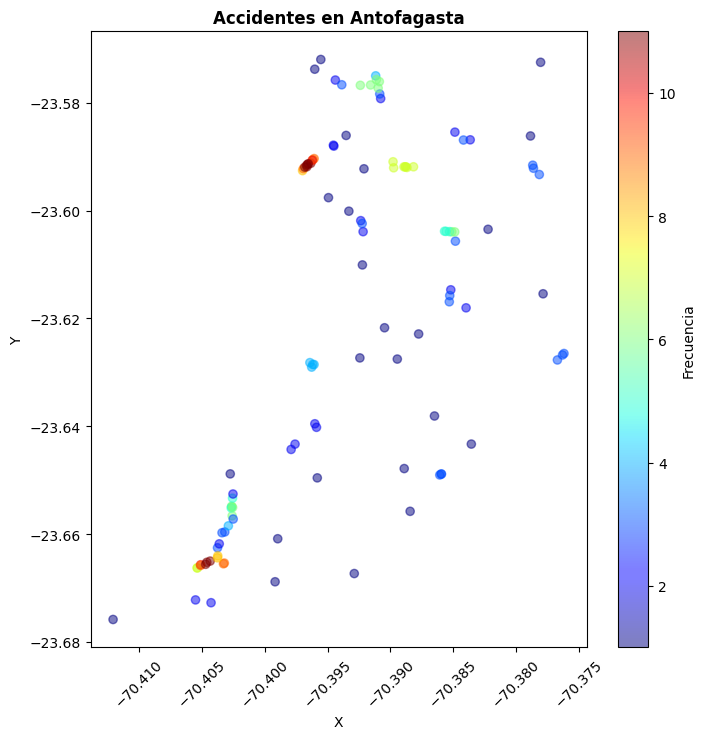

In [431]:
heat_map('ACCIDENT')

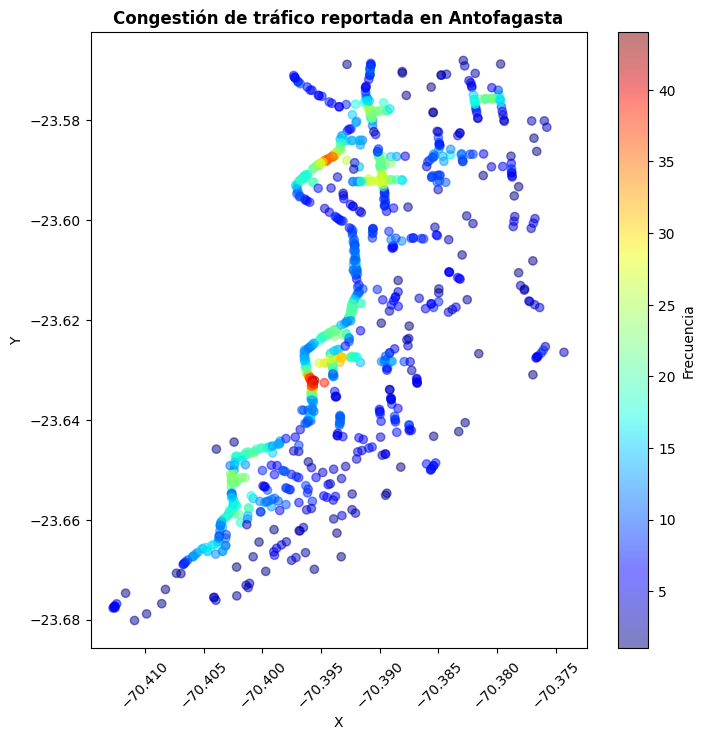

In [432]:
heat_map('JAM')

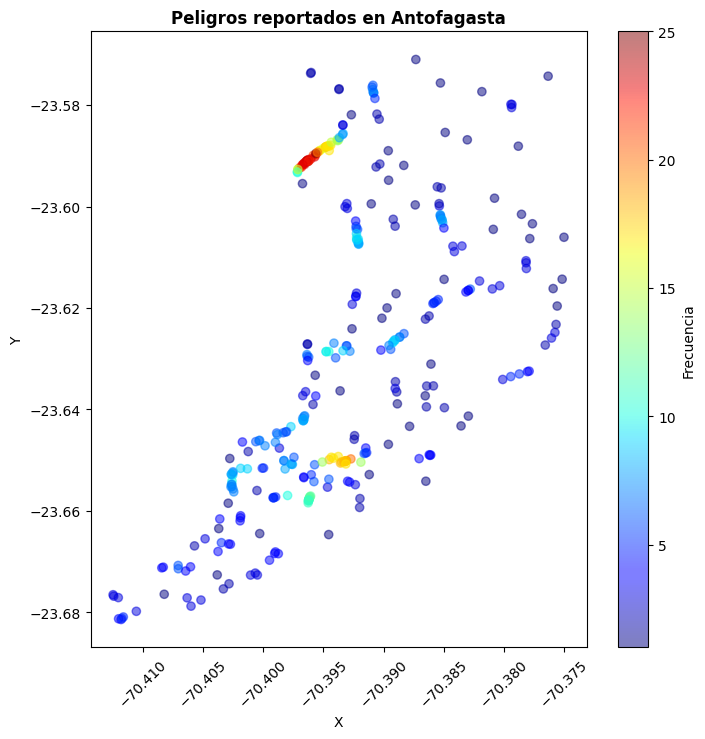

In [433]:
heat_map('HAZARD')